In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (classification_report,
                             mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score,
                             recall_score, precision_score,
                             accuracy_score, confusion_matrix,
                             roc_auc_score)
#from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay

In [ ]:
# https://www.irn.ru/kvartiry/moskva/ceny-po-rayonam/

f = open('metros.txt').readlines()
metros_sorted = []
for row in f:
  row = list(row.split(', '))
  for metro in row:
    metro = metro.replace('\n', '')
    metro = metro.replace(' ', '')
    metro = metro.replace('ё', 'е')
    metro = metro.lower()
    metros_sorted.append(metro)

d = dict(zip(metros_sorted, range(len(metros_sorted))))

In [ ]:
print(d)

{'кропоткинская': 0, 'парккультуры': 1, 'александровскийсад': 2, 'арбатская': 3, 'библиотекаимениленина': 4, 'боровицкая': 5, 'смоленская': 6, 'новокузнецкая': 7, 'полянка': 8, 'третьяковская': 9, 'китай-город': 10, 'кузнецкиймост': 11, 'лубянка': 12, 'охотныйряд': 13, 'площадьреволюции': 14, 'театральная': 15, 'маяковская': 16, 'пушкинская': 17, 'тверская': 18, 'чеховская': 19, 'лужники': 20, 'спортивная': 21, 'фрунзенская': 22, 'баррикадная': 23, 'выставочная': 24, 'деловойцентр': 25, 'краснопресненская': 26, 'международная': 27, 'улица1905года': 28, 'добрынинская': 29, 'октябрьская': 30, 'павелецкая': 31, 'серпуховская': 32, 'курская': 33, 'марксистская': 34, 'таганская': 35, 'чкаловская': 36, 'комсомольская': 37, 'красныеворота': 38, 'сретенскийбульвар': 39, 'тургеневская': 40, 'чистыепруды': 41, 'достоевская': 42, 'проспектмира': 43, 'сухаревская': 44, 'трубная': 45, 'цветнойбульвар': 46, 'киевская': 47, 'кутузовская': 48, 'паркпобеды': 49, 'студенческая': 50, 'белорусская': 51, '

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.shape

(22676, 12)

In [ ]:
df.head()

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation


<Axes: xlabel='Price', ylabel='Count'>

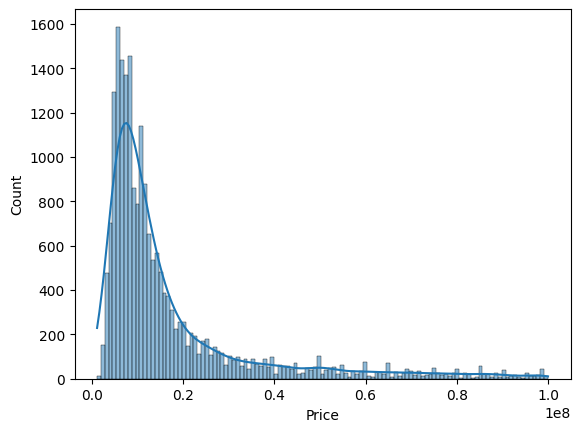

In [ ]:
sns.histplot(data=df[df['Price'] < 10**8], x="Price", kde=True)

Text(0, 0.5, 'Price')

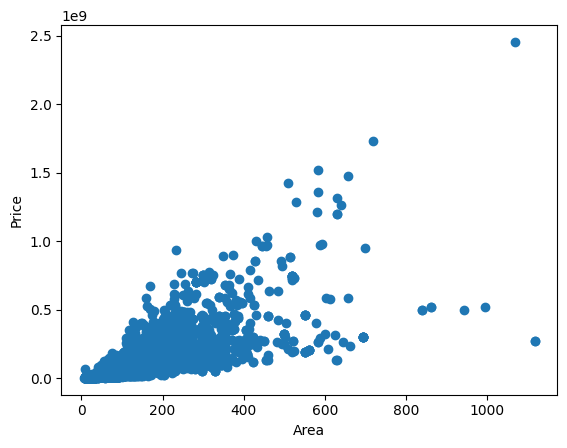

In [ ]:
plt.scatter(df['Area'], df['Price'])
plt.xlabel("Area")
plt.ylabel("Price")

In [ ]:
warnings.filterwarnings('ignore')

df['Metro station'] = df['Metro station'].str.replace(' ', '')
df['Metro station'] = df['Metro station'].str.replace('ё', 'е')
df['Metro station'] = df['Metro station'].str.lower()

df['Metro station'] = df['Metro station'].replace(d)
df = df[df['Metro station'].apply(lambda x: str(x).isdigit())]

df = pd.get_dummies(df, columns = ['Apartment type', 'Renovation', 'Region'], dtype=float)

df = df.dropna()
df = df.reset_index()
df = df.drop(columns = ['index'])

In [ ]:
delta = 1000000

df['Undervalued'] = np.zeros(len(df))

for i in range(len(df)):
  r = (np.random.randint(5) == 0)
  if r:
    df.loc[i, 'Undervalued'] = df.iloc[i]['Undervalued'] + 1
    df.loc[i, 'Price'] = df.iloc[i]['Price'] - delta

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df['Undervalued'],
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    stratify = df['Undervalued'])

In [ ]:
model = RandomForestClassifier(n_estimators=175,
                               criterion='entropy',
                               max_features='sqrt',
                               max_depth=30,
                               min_samples_leaf=5,
                               class_weight='balanced')

model.fit(x_train, y_train)

y_pred = model.predict_proba(x_test)

In [ ]:
y_pred = np.delete(y_pred, np.s_[:1], axis = 1)

df_test = pd.DataFrame(columns=['y_pred', 'y_test'])
df_test['y_pred'] = y_pred.reshape(1,-1)[0]
df_test['y_test'] = y_test.values

threshold = 0.80
df_test = df_test.assign(y_pred2 = lambda x: x.y_pred > threshold)
df_test['y_pred2'] = df_test['y_pred2'].replace({False: 0, True: 1})

In [ ]:
print(classification_report(df_test['y_test'], df_test['y_pred2']))



              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      2950
         1.0       1.00      0.13      0.23       755

    accuracy                           0.82      3705
   macro avg       0.91      0.56      0.56      3705
weighted avg       0.85      0.82      0.76      3705



In [ ]:
precision_score(df_test['y_test'], df_test['y_pred2'], average='binary', pos_label=1)

1.0

In [ ]:
scaler = MinMaxScaler()
df.iloc[:, 1:9] = scaler.fit_transform(df.iloc[:, 1:9])

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df['Undervalued'],
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    stratify = df['Undervalued'])

knc = KNeighborsClassifier()
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      3630
         1.0       0.40      0.19      0.26       906

    accuracy                           0.78      4536
   macro avg       0.61      0.56      0.57      4536
weighted avg       0.74      0.78      0.75      4536



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 1:],
                                                    df['Price'],
                                                    test_size = 0.2,
                                                    random_state = 0)

lin = LinearRegression()
lin.fit(x_train, y_train)
y_pred = lin.predict(x_test)

In [ ]:
delta = 1000000

df_test = pd.DataFrame(columns = ['y_pred', 'y_test', 'Undervalued'])
df_test['y_test'] = y_test
df_test['y_pred'] = y_pred
df_test['Undervalued'] = np.zeros(len(y_test))
df_test = df_test.reset_index()
df_test = df_test.drop(columns = 'index')

for i in range(len(y_test)):
  r = (np.random.randint(5) == 0)
  if r:
    df_test.loc[i, 'Undervalued'] = df_test.iloc[i]['Undervalued'] + 1
    df_test.loc[i, 'y_test'] = df_test.iloc[i]['y_test'] - delta

df_test = df_test.assign(dif = lambda x: ((x.y_pred - x.y_test) > 1000000))
df_test['dif'] = df_test['dif'].replace({False: 0, True: 1})

In [ ]:
print(classification_report(df_test['Undervalued'], df_test['dif']))



              precision    recall  f1-score   support

         0.0       0.81      0.51      0.63      2972
         1.0       0.21      0.51      0.29       733

    accuracy                           0.51      3705
   macro avg       0.51      0.51      0.46      3705
weighted avg       0.69      0.51      0.56      3705



In [ ]:
oldprice = df['Price']

df_metrics = pd.DataFrame(columns=['delta', 'accuracy', 'precision', 'recall'])


for delta in range(0, 1500000, 50000):
    df['Undervalued'] = np.zeros(len(df))
    df['Price'] = oldprice
    for i in range(len(df)):
        r = (np.random.randint(5) == 0)
        if r:
            df.loc[i, 'Undervalued'] = df.iloc[i]['Undervalued'] + 1
            df.loc[i, 'Price'] = df.iloc[i]['Price'] - delta

    x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                      df['Undervalued'],
                                                      test_size = 0.2,
                                                      random_state = 0,
                                                      stratify = df['Undervalued'])

    model = RandomForestClassifier(n_estimators=175,
                                criterion='entropy',
                                max_features='sqrt',
                                max_depth=30,
                                min_samples_leaf=5,
                                class_weight='balanced')

    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    y_pred = np.delete(y_pred, np.s_[:1], axis = 1)
    df_test = pd.DataFrame(columns=['y_pred', 'y_test'])
    df_test['y_pred'] = y_pred.reshape(1,-1)[0]
    df_test['y_test'] = y_test.values
    threshold = 0.80
    df_test = df_test.assign(y_pred2 = lambda x: x.y_pred > threshold)
    df_test['y_pred2'] = df_test['y_pred2'].replace({False: 0, True: 1})

    result = pd.DataFrame({'delta':[delta],
                           'accuracy':[accuracy_score(df_test['y_test'], df_test['y_pred2'])],
                           'precision':[precision_score(df_test['y_test'], df_test['y_pred2'])],
                           'recall':[recall_score(df_test['y_test'], df_test['y_pred2'])]})

    df_metrics = pd.concat([df_metrics, result])

In [ ]:
df_metrics

Text(0.5, 1.0, 'Зависимость метрик от дельты')

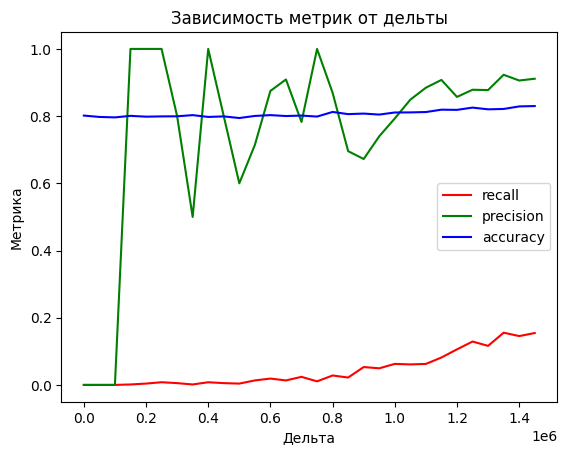

In [ ]:
plt.plot(df_metrics['delta'], df_metrics['recall'], 'r', label='recall')
plt.plot(df_metrics['delta'], df_metrics['precision'], 'g', label='precision')
plt.plot(df_metrics['delta'], df_metrics['accuracy'], 'b', label='accuracy')
plt.legend()
plt.xlabel('Дельта')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от дельты')



[Text(0, 0, '0.51'), Text(0, 0, '0.19'), Text(0, 0, '0.11')]

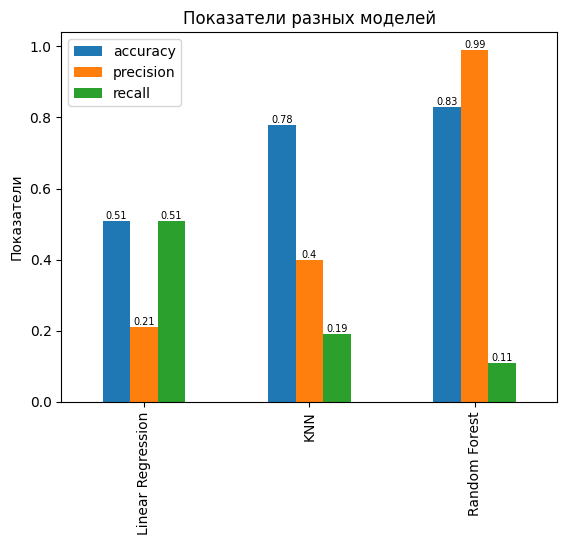

In [ ]:
df_metrics = pd.DataFrame({'model':['Linear Regression', 'KNN', 'Random Forest'],
                            'accuracy':[0.51, 0.78, 0.83],
                            'precision':[0.21, 0.4, 0.99],
                            'recall':[0.51, 0.19, 0.11]})

fig, ax = plt.subplots(1)
df_metrics.plot(kind='bar', ax=ax)
ax.set_xticks([0,1,2], ['Linear Regression', 'KNN', 'Random Forest'])
ax.set_ylabel('Показатели')
ax.set_title('Показатели разных моделей')
ax.bar_label(ax.containers[0], label_type='edge', fontsize=7)
ax.bar_label(ax.containers[1], label_type='edge', fontsize=7)
ax.bar_label(ax.containers[2], label_type='edge', fontsize=7)




Text(0.5, 1.0, 'Матрица ошибок')

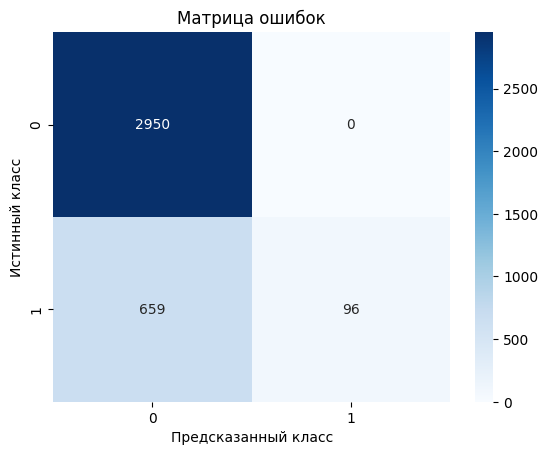

In [ ]:
cm = confusion_matrix(df_test['y_test'], df_test['y_pred2'])
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
ax.set_title('Матрица ошибок')



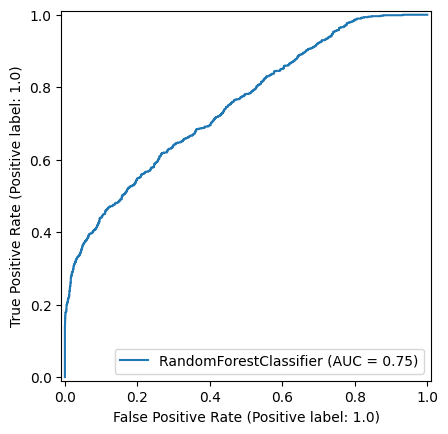

In [ ]:
#plot_roc_curve(y_test, y_pred, ax=ax)
svc_disp = RocCurveDisplay.from_estimator(model, x_test, y_test)